### Import Libraries

In [ ]:
!pip install haversine # If haversine is not installed

In [21]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

### For Colab Env

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
df = pd.read_csv("/content/drive/MyDrive/UNI-STUFF/SC1015/airbnb.csv")

#### Light Cleaning of Data

In [30]:
df['price'] = np.exp(df["log_price"])

### Load Dataset (Non-Colab)

In [ ]:
df = pd.read_csv('Dataset/airbnb.csv')

### Rationale for Investigating Landmark Proximity
Our exploratory data analysis (EDA) on geospatial features revealed intriguing patterns suggesting that geography plays a significant role in influencing Airbnb pricing. Landmarks, being central to a city's identity and tourist appeal, are hypothesized to impact accommodation desirability. By engineering features based on proximity and density of landmarks, we aim to uncover their relationship with pricing for airbnb listings.

### Landmark Data Sources
The landmark data was sourced from the following Wikipedia pages:
- [List of Chicago Landmarks](https://en.wikipedia.org/wiki/List_of_Chicago_Landmarks)
- [List of National Historic Landmarks in New York City](https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_New_York_City)
- [California Historical Landmarks in Los Angeles County](https://en.wikipedia.org/wiki/California_Historical_Landmarks_in_Los_Angeles_County)
- [List of San Francisco Designated Landmarks](https://en.wikipedia.org/wiki/List_of_San_Francisco_Designated_Landmarks)
- [List of National Historic Landmarks in Washington, D.C.](https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Washington,_D.C)
- [List of National Historic Landmarks in Boston](https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Boston)

#### Function to load data from multiple .csv in a folder

In [60]:
def load_data_from_folder(folder_path):
    """
    Load and concatenate data from CSV files in a specified folder.

    Args:
        folder_path (str): Path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: A concatenated DataFrame with an additional 'city' column.
    """
    # List to store data from each CSV
    data = []

    # Loop through all files in the specified folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Check if the file is a CSV
            file_path = os.path.join(folder_path, file_name)  # Full path to the file
            city_df = pd.read_csv(file_path)  # Read the CSV into a DataFrame
            city_name = file_name.replace(".csv", "")  # Extract the city name from the file name
            city_df["city"] = city_name  # Add a column for the city name
            data.append(city_df)  # Append the DataFrame to the list

    # Concatenate all the city DataFrames into a single DataFrame
    concatenated_df = pd.concat(data, ignore_index=True)

    return concatenated_df

#### Load Landmark Data and Clean

In [66]:
landmark_folder_path = "/content/drive/MyDrive/UNI-STUFF/SC1015/landmarks"
landmark_df = load_data_from_folder(landmark_folder_path)
landmark_df.drop(columns=['Unnamed: 0', 'Image', 'Date designated',
       'Description', 'Unnamed: 1', 'City or town', 'Summary',
       'County', 'Designation date', 'Construction date or period', 'Community Area', 'NRHP date',
       'NHL date', '#', 'Address'], inplace=True)
landmark_df.dropna(inplace=True)

In [68]:
regex = r"(\d{1,3}\.\d+)\s*[°]?\s*;\s*(-?\d{1,3}\.\d+)" # Regex to filter out coordinates

# Extract coordinates into two new columns: X (latitude) and Y (longitude)
landmark_df[["X", "Y"]] = landmark_df["Location"].str.extract(regex)

# Convert the new columns to numeric for further processing
landmark_df["X"] = pd.to_numeric(landmark_df["X"])
landmark_df["Y"] = pd.to_numeric(landmark_df["Y"])

landmark_df.drop("Location", axis=1, inplace=True)
landmark_df

,Landmark name,city,X,Y
0,227 East Walton Place Apartment Building,Chicago,41.900056,-87.620750
1,300 West Adams Building,Chicago,41.879720,-87.635830
2,333 North Michigan Building,Chicago,41.887780,-87.624170
3,35 East Wacker Building,Chicago,41.886390,-87.626670
4,42nd Precinct / Town Hall Police Station,Chicago,41.947500,-87.650000
...,...,...,...,...
1109,"Well, Alamitos #1",LA,33.797222,-118.158809
1110,"Well, CSO 4",LA,34.369444,-118.630278
1111,Western Hotel,LA,34.698283,-118.139000
1112,Workman Home and Family Cemetery,LA,34.020000,-117.964166


### Feature Engineering with Landmark Data

#### Haversine Function

In [22]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Args:
        lat1, lon1: Latitude and longitude of point 1 (in degrees).
        lat2, lon2: Latitude and longitude of point 2 (in degrees).

    Returns:
        Distance in meters.
    """
    R = 6371000  # Radius of Earth in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

#### Create Features
We create features such as:
-  Number of Landmarks within 500m
-  Number of Landmarks within 1000m
-  Number of Landmarks within 5000m
-  Average distance to Landmarks within City

In [76]:
# Normalize city names
df["city"] = df["city"].str.strip().str.lower()
landmark_df["city"] = landmark_df["city"].str.strip().str.lower()

# Initialize new columns
df["landmarks_within_500m"] = 0
df["landmarks_within_1000m"] = 0
df["landmarks_within_2000m"] = 0
df["avg_distance_to_landmarks"] = np.nan

In [78]:
# Loop through each row in the Airbnb dataframe
for index, airbnb in df.iterrows():
    # Get Airbnb location and city
    airbnb_lat = airbnb["latitude"]
    airbnb_lon = airbnb["longitude"]
    airbnb_city = airbnb["city"]

    # Filter landmarks in the same city
    city_landmarks = landmark_df[landmark_df["city"] == airbnb_city]

    # If no landmarks exist for the city, skip to the next Airbnb property
    if city_landmarks.empty:
        continue

    # Calculate distances between the Airbnb property and all landmarks in the city
    distances = city_landmarks.apply(
        lambda row: haversine(airbnb_lat, airbnb_lon, row["X"], row["Y"]),
        axis=1
    )

    # Count landmarks within distance thresholds
    df.at[index, "landmarks_within_500m"] = sum(distances <= 500)
    df.at[index, "landmarks_within_1000m"] = sum(distances <= 1000)
    df.at[index, "landmarks_within_2000m"] = sum(distances <= 2000)

    # Calculate the average distance to landmarks (if there are any landmarks)
    if not distances.empty:
        df.at[index, "avg_distance_to_landmarks"] = distances.mean()

In [79]:
df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,landmarks_within_500m,landmarks_within_1000m,landmarks_within_2000m,avg_distance_to_landmarks
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,4,4,12,8175.547262
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0,1,19,6995.324807
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0,4,10,9722.553044
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,1,8,18,2979.908547
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,4,40.0,NaN,20009,0.0,1.0,2,3,18,3355.135192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,...,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0,0,0,0,8722.536150
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0,0,0,0,35020.547213
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0,0,0,0,8714.517372
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,...,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0,1,9,27,6485.150356


### Let's see how these engineered features perform in correlation

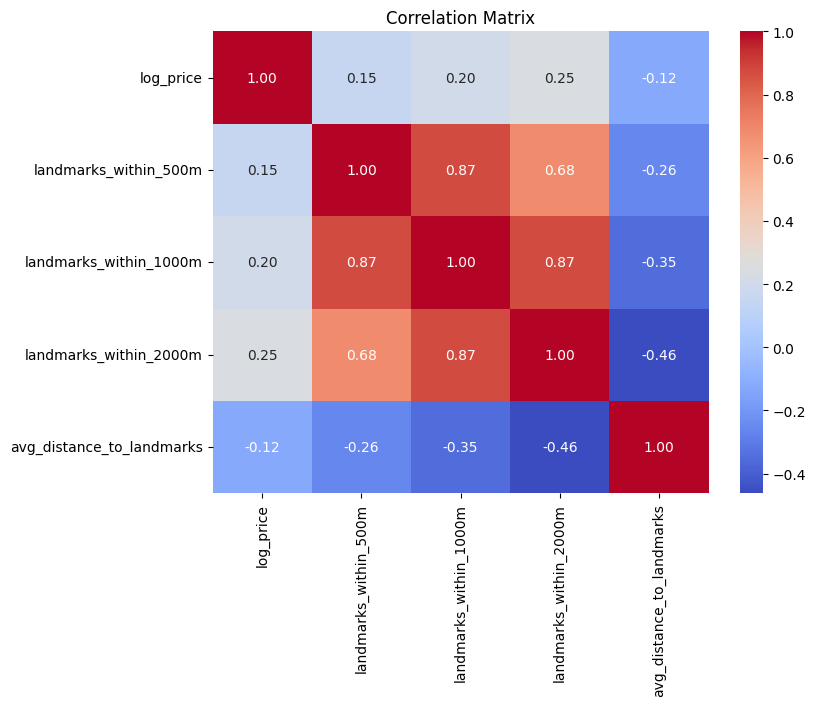

In [81]:
# Select columns of interest for correlation
columns_of_interest = ["log_price", "landmarks_within_500m", "landmarks_within_1000m", "landmarks_within_2000m", "avg_distance_to_landmarks"]
# Ensure numeric columns only
corr_df = df[columns_of_interest].corr()
# Plot heatmap for correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Summary of Landmark Feature Correlations

From the correlation analysis, we observe the following:

1. **Weak Positive Correlation with Price**:
   - The number of landmarks within **500m**, **1000m**, and **2000m** shows a weak positive correlation with log-transformed Airbnb prices (`log_price`).
   - Properties surrounded by more landmarks within larger radii tend to have slightly higher prices, with landmarks within **2000m** having the strongest correlation (0.25).

2. **Negative Correlation of Average Distance**:
   - The `avg_distance_to_landmarks` feature has a weak negative correlation (-0.12) with prices.
   - This indicates that properties farther away from landmarks are generally priced lower, though the effect is minimal.

3. **Interpretation**:
   - While the correlations are weak, they suggest that proximity to landmarks may still contribute to pricing when combined with other factors.
   - Dense clusters of landmarks or their proximity could reflect the centrality and desirability of a location, which might indirectly influence prices.

### Conclusion

Although the correlations between landmark features and price are not strong, they provide insight into how proximity to landmarks can marginally affect Airbnb pricing. These features may be more impactful when analyzed in conjunction with other geographic or neighborhood-based attributes.

### Save New Data with engineered features

In [82]:
# Define the path where the new dataset will be saved
output_file_path = "/content/drive/MyDrive/UNI-STUFF/SC1015/airbnb_with_landmark_features.csv"

# Save the DataFrame as a CSV file
df.to_csv(output_file_path, index=False)